<a href="https://colab.research.google.com/github/SiriusBits/ml-engineering-lab/blob/main/notebooks/regression-algs/Solutions_nyc_taxi_data_mwyss.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Library

In [ ]:
import pandas as pd
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import KFold
pd.set_option('display.max_colwidth', None)
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)
import numpy as np
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Read Data From Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In this playground competition, you are tasked with predicting the fare amount (inclusive of tolls) for a taxi ride in New York City given the pickup and dropoff locations. You can get a basic estimate based on just the distance between the two points, this will result in an RMSE of $5-$8.

This is a large dataset something which is not covered yet in the class  but feel free to to look at the various techniques used to handle it.



In [ ]:
data_path = "/content/drive/My Drive/ML-09: Regression Algorithms/Assignment & MCQ/Assignment  Datasets"
data = pd.read_csv(f"{data_path}/train.csv", nrows=100000)

# EDA & Feature Engineering

## Summary statistics and missing values

In [ ]:
data.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,11.354652,-72.494682,39.914481,-72.490967,39.919053,1.673820
std,9.716777,10.693934,6.225686,10.471386,6.213427,1.300171
min,-44.900000,-736.550000,-74.007670,-84.654241,-74.006377,0.000000
25%,6.000000,-73.992041,40.734996,-73.991215,40.734182,1.000000
50%,8.500000,-73.981789,40.752765,-73.980000,40.753243,1.000000
75%,12.500000,-73.966982,40.767258,-73.963433,40.768166,2.000000
max,200.000000,40.787575,401.083332,40.851027,404.616667,6.000000


In [ ]:
# Check for missing values
data.isnull().sum()

key                  0
fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
passenger_count      0
dtype: int64

In [ ]:
# remove value where fare < 0
data = data[data["fare_amount"] > 0]

In [ ]:
len(data)

99988

In [ ]:
# Convert the pickup_datetime column to datetime type
data['pickup_datetime'] = pd.to_datetime(data['pickup_datetime'])

# Extract year, month, day, and hour from the pickup_datetime column
data['year'] = data['pickup_datetime'].dt.year
data['month'] = data['pickup_datetime'].dt.month
data['day'] = data['pickup_datetime'].dt.day
data['hour'] = data['pickup_datetime'].dt.hour

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99988 entries, 0 to 99999
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype              
---  ------             --------------  -----              
 0   key                99988 non-null  object             
 1   fare_amount        99988 non-null  float64            
 2   pickup_datetime    99988 non-null  datetime64[ns, UTC]
 3   pickup_longitude   99988 non-null  float64            
 4   pickup_latitude    99988 non-null  float64            
 5   dropoff_longitude  99988 non-null  float64            
 6   dropoff_latitude   99988 non-null  float64            
 7   passenger_count    99988 non-null  int64              
 8   year               99988 non-null  int64              
 9   month              99988 non-null  int64              
 10  day                99988 non-null  int64              
 11  hour               99988 non-null  int64              
dtypes: datetime64[ns, UTC](1), float64(5), int64(5

## Distance Calculation

We will calculate distance with Haversine Formula. The Haversine formula returns the shortest distance between two points on the surface of a sphere (in km).

Pros of Haversine Formula:
1. Accuracy: The Haversine formula is more accurate for calculating distances between two points on the Earth's surface, as it takes into account the Earth's curvature.
2. Applicability: The Haversine formula is specifically designed for calculating great-circle distances on a sphere, making it suitable for geospatial applications, such as navigation and geodesy.
3. Consistent results: The Haversine formula provides consistent results for distances on a global scale, whereas the Euclidean distance can produce significant errors when used for long distances.

Cons of Haversine Formula:
1. Complexity: The Haversine formula is more complex than the Euclidean distance, requiring trigonometric functions and additional calculations.
2. Performance: Due to its complexity, the Haversine formula can be slower to compute than the Euclidean distance, especially when dealing with large datasets.
3. Assumptions: The Haversine formula assumes a perfect sphere, while the Earth is more of an oblate spheroid. This can lead to some inaccuracies, especially at high latitudes.

In [ ]:
!pip install haversine

In [ ]:
from haversine import haversine

In [ ]:
def calculate_distance(row):
    pickup = (row['pickup_latitude'], row['pickup_longitude'])
    dropoff = (row['dropoff_latitude'], row['dropoff_longitude'])
    return haversine(pickup, dropoff)

Time for some Geography

Latitude and longitude values are used to represent geographical coordinates on the Earth's surface. They are measured in degrees and have specific ranges that correspond to valid locations on Earth.

Latitude values range from -90 to +90 degrees, where -90 represents the South Pole, 0 represents the Equator, and +90 represents the North Pole.

Longitude values range from -180 to +180 degrees, where -180 corresponds to the Prime Meridian (which passes through Greenwich, London), and +180 corresponds to the 180th meridian, which is on the opposite side of the Earth.

These ranges are based on the Earth's geometry and are used to ensure that latitude and longitude values correspond to actual locations on the Earth's surface. If a latitude or longitude value is outside its respective range, it is considered invalid and most likely represents an error in the data.

In [ ]:
# Filter out rows with invalid latitude and longitude values
valid_latitude_range = (-90, 90)
valid_longitude_range = (-180, 180)

data = data[(data['pickup_latitude'].between(*valid_latitude_range)) &
            (data['pickup_longitude'].between(*valid_longitude_range)) &
            (data['dropoff_latitude'].between(*valid_latitude_range)) &
            (data['dropoff_longitude'].between(*valid_longitude_range))]

In [ ]:
len(data)

99985

In [ ]:
#let's rerun earlier code
data['distance'] = data.apply(calculate_distance, axis=1)

# Drop the key and pickup_datetime columns as they are not needed for EDA
data.drop(['key', 'pickup_datetime'], axis=1, inplace=True)

In [ ]:
data.head()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,day,hour,distance
0,4.5,-73.844311,40.721319,-73.841610,40.712278,1,2009,6,15,17,1.030765
1,16.9,-74.016048,40.711303,-73.979268,40.782004,1,2010,1,5,16,8.450145
2,5.7,-73.982738,40.761270,-73.991242,40.750562,2,2011,8,18,0,1.389527
3,7.7,-73.987130,40.733143,-73.991567,40.758092,1,2012,4,21,4,2.799274
4,5.3,-73.968095,40.768008,-73.956655,40.783762,1,2010,3,9,7,1.999160


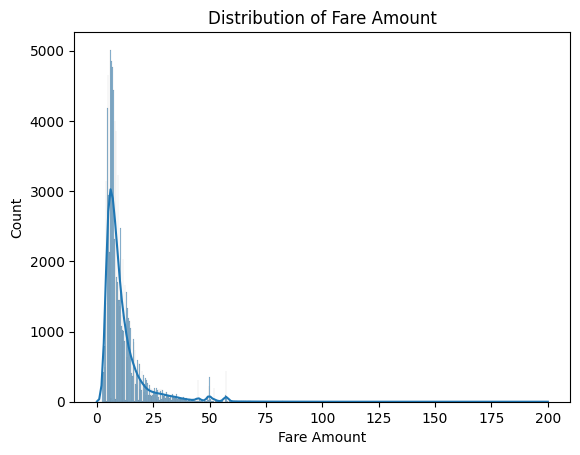

In [ ]:
# Plot the distribution of fare_amount
sns.histplot(data['fare_amount'], kde=True)
plt.title("Distribution of Fare Amount")
plt.xlabel("Fare Amount")
plt.show()

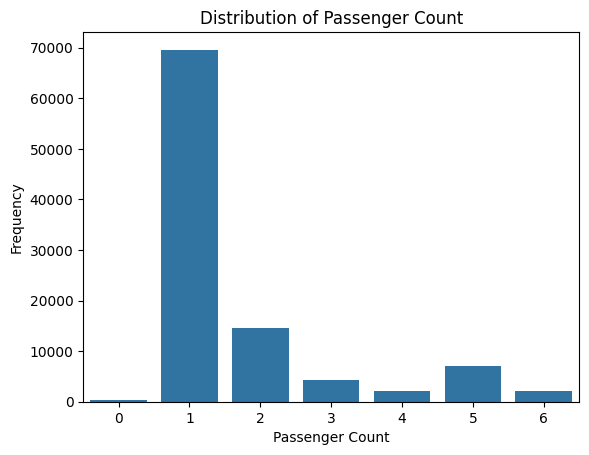

In [ ]:
# Plot the distribution of passenger_count
sns.countplot(x=data['passenger_count'])
plt.title("Distribution of Passenger Count")
plt.xlabel("Passenger Count")
plt.ylabel("Frequency")
plt.show()

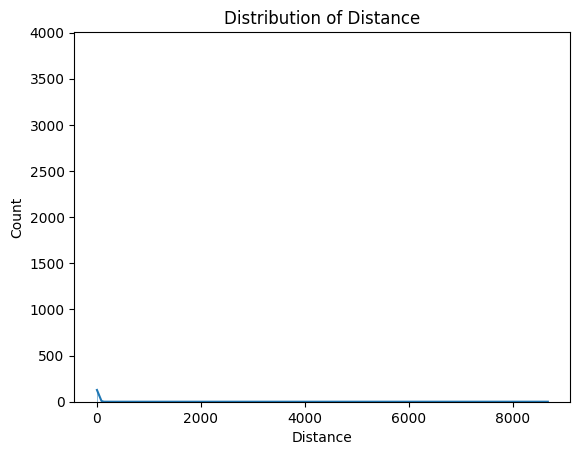

In [ ]:
# Plot the distribution of distance
sns.histplot(data['distance'], kde=True)
plt.title("Distribution of Distance")
plt.xlabel("Distance")
plt.show()

In [ ]:
data['distance'].describe()

count    99997.000000
mean        18.540604
std        356.451652
min          0.000000
25%          1.214408
50%          2.119244
75%          3.887684
max       8674.633812
Name: distance, dtype: float64

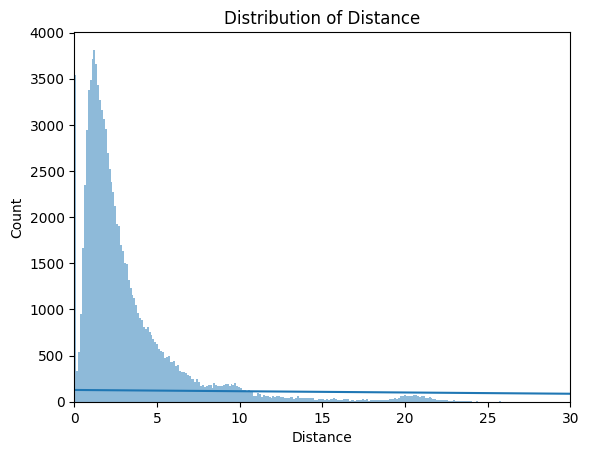

In [ ]:
# Plot the distribution of distance
sns.histplot(data['distance'], kde=True)
plt.title("Distribution of Distance")
plt.xlabel("Distance")
plt.xlim(0, 30)  # There are some outliers
plt.show()

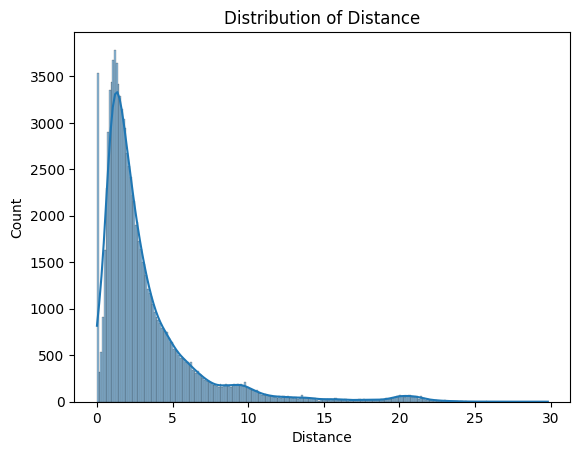

In [ ]:
# Plot the distribution of distance
sns.histplot(data.loc[data['distance'] <= 30, 'distance'], kde=True)
plt.title("Distribution of Distance")
plt.xlabel("Distance")
plt.show()

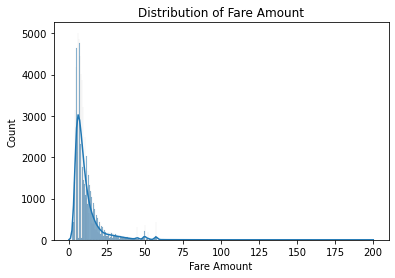

In [ ]:
# Plot the distribution of fare_amount
sns.histplot(data['fare_amount'], kde=True)
plt.title("Distribution of Fare Amount")
plt.xlabel("Fare Amount")
plt.show()

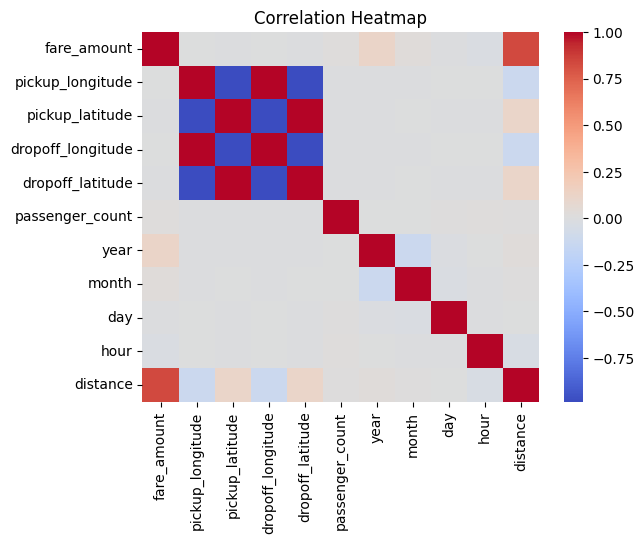

In [ ]:
# Plot the heatmap of correlations between features
corr = data.loc[data['distance'] <= 30].corr()
sns.heatmap(corr, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

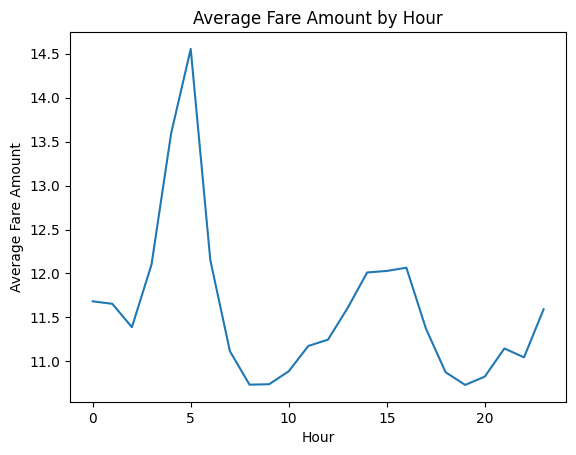

In [ ]:
# Plot the average fare_amount by hour
avg_fare_by_hour = data.groupby('hour')['fare_amount'].mean()
sns.lineplot(x=avg_fare_by_hour.index, y=avg_fare_by_hour.values)
plt.title("Average Fare Amount by Hour")
plt.xlabel("Hour")
plt.ylabel("Average Fare Amount")
plt.show()

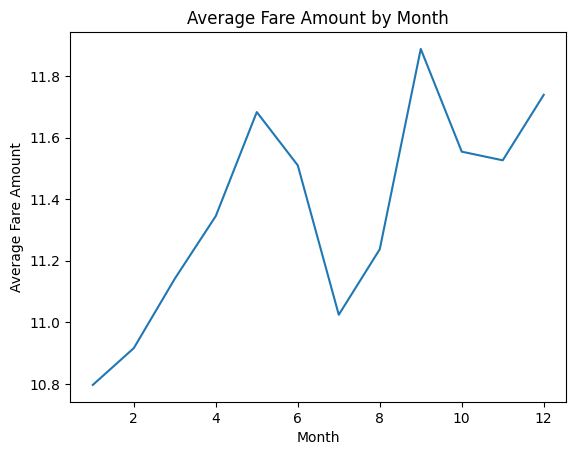

In [ ]:
# Plot the average fare_amount by month
avg_fare_by_month = data.groupby('month')['fare_amount'].mean()
sns.lineplot(x=avg_fare_by_month.index, y=avg_fare_by_month.values)
plt.title("Average Fare Amount by Month")
plt.xlabel("Month")
plt.ylabel("Average Fare Amount")
plt.show()

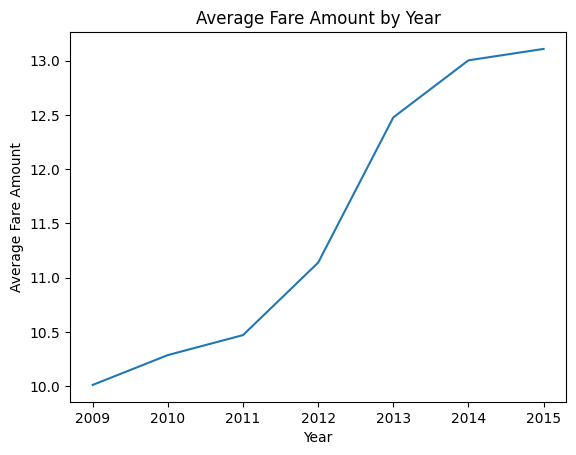

In [ ]:
# Plot the average fare_amount by year
avg_fare_by_year = data.groupby('year')['fare_amount'].mean()
sns.lineplot(x=avg_fare_by_year.index, y=avg_fare_by_year.values)
plt.title("Average Fare Amount by Year")
plt.xlabel("Year")
plt.ylabel("Average Fare Amount")
plt.show()

In [ ]:
# Remove outliers (assuming data has already been cleaned for missing values and invalid coordinates)
data = data[(data['fare_amount'].between(1, 200)) &
            (data['distance'].between(0.1, 100)) &
            (data['passenger_count'].between(1, 6))]

In [ ]:
len(data)

95913

## Train Test Split

**Task**:

a. Define the features (X) by dropping the 'fare_amount', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', and 'dropoff_latitude' columns from the 'data' DataFrame.

b. Scale the features using the `StandardScaler` from the `sklearn.preprocessing` module. Store the scaled features in a variable named `X_scaled`.

c. Define the target variable (y) as the 'fare_amount' column from the 'data' DataFrame.

d. Split the dataset into training and testing sets using the `train_test_split` function from the `sklearn.model_selection` module. Use an 80-20 split with a random state of 42. Store the split data in the variables `X_train`, `X_test`, `y_train`, and `y_test`.

In [ ]:
# Define the features and target variable
X = data.drop(['fare_amount', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude'], axis=1)
y = data['fare_amount']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Model Training

In [ ]:
# Train the Ridge Regression model
ridge_model = Ridge(alpha=1.0)
ridge_model.fit(X_train_scaled, y_train)

# Train the Linear Regression model
linear_model = LinearRegression()
linear_model.fit(X_train_scaled, y_train)

LinearRegression()

In [ ]:
ridge_model.coef_

array([0.05907604, 1.05972218, 0.28226222, 0.01934731, 0.05220742,
       7.88906761])

In [ ]:
linear_model.coef_

array([0.05907552, 1.05973489, 0.28226658, 0.01934783, 0.05221123,
       7.88917031])

In [ ]:
# Make predictions using the Ridge Regression model
ridge_preds = ridge_model.predict(X_test_scaled)

# Make predictions using the Linear Regression model
linear_preds = linear_model.predict(X_test_scaled)

In [ ]:
ridge_preds

array([ 7.37189806,  9.4559887 , 11.9253269 , ...,  7.87514626,
        5.47643371,  9.52062262])

In [ ]:
linear_preds

array([ 7.37185144,  9.45597127, 11.92533798, ...,  7.87509711,
        5.47635335,  9.52060037])

In [ ]:
# Calculate the RMSE for the Ridge Regression model
ridge_rmse = np.sqrt(mean_squared_error(y_test, ridge_preds))
print(f"Ridge Regression RMSE: {ridge_rmse}")

# Calculate the RMSE for the Linear Regression model
linear_rmse = np.sqrt(mean_squared_error(y_test, linear_preds))
print(f"Linear Regression RMSE: {linear_rmse}")

Ridge Regression RMSE: 4.356858929109788
Linear Regression RMSE: 4.356843949734936


In [ ]:
# Perform hyperparameter tuning for Ridge Regression
# Perform hyperparameter tuning for Ridge Regression with additional parameters
ridge_params = {
    #'alpha': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 1, 10, 100],
    'alpha': [1, 10, 100],
    'solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']
}

grid_search = GridSearchCV(ridge_model, param_grid=ridge_params, cv=2,
                           scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)

# Get the best Ridge Regression model
best_ridge = grid_search.best_estimator_

# Train the best Ridge Regression model on the training data
best_ridge.fit(X_train_scaled, y_train);

# Make predictions on the testing data
ridge_preds = best_ridge.predict(X_test_scaled);

# Calculate the RMSE for the best Ridge Regression model
ridge_rmse = np.sqrt(mean_squared_error(y_test, ridge_preds))
print(f"Best Ridge Regression RMSE: {ridge_rmse}")

Best Ridge Regression RMSE: 4.358431209827145
